In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *

In [ ]:
# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim

model.solve()
model.simulate()

In [3]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [4]:
# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "r_a", "xi")
theta_init = np.array([0.955 , 0.85 , 4.5, 5.000, 0.005, 0.02])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 10.0),  # mu
               (0.0, 0.1),   # r_a
               (0.0, 1.0),    # k_scale
               (0.0, 0.1),
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

In [5]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean, weights, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='nelder-mead',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":100}
)


beta=0.955 sigma=0.850 gamma=4.500 mu=5.000 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 34.06, Time = 126.5592 seconds
beta=0.997 sigma=0.850 gamma=4.500 mu=5.000 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 44.74, Time = 137.0885 seconds
beta=0.955 sigma=0.888 gamma=4.500 mu=5.000 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 33.26, Time = 119.5722 seconds
beta=0.955 sigma=0.850 gamma=4.720 mu=5.000 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 34.06, Time = 117.1891 seconds
beta=0.955 sigma=0.850 gamma=4.500 mu=5.250 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 33.74, Time = 122.5700 seconds
beta=0.955 sigma=0.850 gamma=4.500 mu=5.000 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 34.02, Time = 121.3028 seconds
beta=0.955 sigma=0.850 gamma=4.500 mu=5.000 r_a=0.005 xi=0.021 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 33.98, Time = 123.5222 seconds
beta=0.913 sigma=0.862 gamma=4.573 mu=5.083 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 38.71, Time = 137.4913 seconds
beta=0.934 sigma=0.859 gamma=4.555 mu=5.062 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 36.73, Time = 135.1669 seconds
beta=0.976 sigma=0.853 gamma=4.518 mu=5.021 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 26.88, Time = 132.3155 seconds
beta=0.997 sigma=0.850 gamma=4.500 mu=5.000 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 44.74, Time = 125.0341 seconds
beta=0.962 sigma=0.864 gamma=4.579 mu=5.090 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 31.58, Time = 121.6707 seconds
beta=0.964 sigma=0.868 gamma=4.313 mu=5.120 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 30.48, Time = 121.7934 seconds
beta=0.968 sigma=0.874 gamma=4.470 mu=5.160 r_a=0.005 xi=0.021 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 28.97, Time = 127.9992 seconds
beta=0.972 sigma=0.882 gamma=4.460 mu=5.214 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 26.77, Time = 124.4848 seconds
beta=0.980 sigma=0.898 gamma=4.440 mu=5.321 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.12, Time = 143.5017 seconds
beta=0.980 sigma=0.898 gamma=4.440 mu=4.988 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.17, Time = 144.9398 seconds
beta=0.988 sigma=0.864 gamma=4.420 mu=5.234 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 30.24, Time = 121.1560 seconds
beta=0.990 sigma=0.888 gamma=4.288 mu=5.191 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 29.18, Time = 146.6925 seconds
beta=0.996 sigma=0.891 gamma=4.546 mu=5.184 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 40.23, Time = 141.5923 seconds
beta=0.972 sigma=0.874 gamma=4.371 mu=5.136 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 26.89, Time = 152.4968 seconds
beta=0.967 sigma=0.898 gamma=4.422 mu=5.039 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 28.82, Time = 143.4405 seconds
beta=0.958 sigma=0.877 gamma=4.600 mu=5.031 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 32.66, Time = 153.0971 seconds
beta=0.982 sigma=0.885 gamma=4.366 mu=5.151 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.75, Time = 130.5631 seconds
beta=0.985 sigma=0.895 gamma=4.383 mu=5.058 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 25.25, Time = 156.1249 seconds
beta=0.992 sigma=0.870 gamma=4.417 mu=5.186 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 33.64, Time = 132.5900 seconds
beta=0.973 sigma=0.891 gamma=4.421 mu=5.076 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 26.24, Time = 138.7692 seconds
beta=0.986 sigma=0.900 gamma=4.485 mu=5.068 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 25.75, Time = 146.1666 seconds
beta=0.986 sigma=0.936 gamma=4.327 mu=5.200 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.57, Time = 124.9291 seconds
beta=0.993 sigma=0.913 gamma=4.392 mu=5.186 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 31.70, Time = 123.6552 seconds
beta=0.978 sigma=0.896 gamma=4.414 mu=5.103 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.46, Time = 136.0014 seconds
beta=0.977 sigma=0.903 gamma=4.305 mu=5.205 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.50, Time = 120.5771 seconds
beta=0.976 sigma=0.911 gamma=4.381 mu=5.265 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.62, Time = 133.5095 seconds
beta=0.977 sigma=0.929 gamma=4.403 mu=5.210 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.14, Time = 153.1455 seconds
beta=0.983 sigma=0.909 gamma=4.395 mu=5.078 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.32, Time = 137.8225 seconds
beta=0.973 sigma=0.875 gamma=4.473 mu=5.102 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 26.80, Time = 136.1786 seconds
beta=0.983 sigma=0.921 gamma=4.363 mu=5.175 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 23.87, Time = 123.3438 seconds
beta=0.983 sigma=0.914 gamma=4.514 mu=5.086 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.23, Time = 120.5235 seconds
beta=0.984 sigma=0.927 gamma=4.438 mu=5.182 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.06, Time = 119.4525 seconds
beta=0.979 sigma=0.920 gamma=4.471 mu=5.243 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 23.90, Time = 118.0901 seconds
beta=0.978 sigma=0.917 gamma=4.338 mu=5.287 r_a=0.005 xi=0.020 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.04, Time = 121.2172 seconds
beta=0.980 sigma=0.939 gamma=4.378 mu=5.485 r_a=0.005 xi=0.018 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 23.50, Time = 121.1251 seconds
beta=0.980 sigma=0.959 gamma=4.346 mu=5.734 r_a=0.005 xi=0.017 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 22.10, Time = 123.0671 seconds
beta=0.984 sigma=0.918 gamma=4.396 mu=5.438 r_a=0.005 xi=0.018 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.27, Time = 133.7832 seconds
beta=0.979 sigma=0.926 gamma=4.401 mu=5.267 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 23.83, Time = 144.2334 seconds
beta=0.981 sigma=0.958 gamma=4.346 mu=5.308 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 22.33, Time = 140.2729 seconds
beta=0.976 sigma=0.940 gamma=4.317 mu=5.489 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 24.09, Time = 142.0944 seconds
beta=0.982 sigma=0.930 gamma=4.408 mu=5.259 r_a=0.005 xi=0.019 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 23.72, Time = 132.0137 seconds
beta=0.984 sigma=0.955 gamma=4.440 mu=5.375 r_a=0.005 xi=0.018 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 22.94, Time = 144.5345 seconds
beta=0.984 sigma=0.963 gamma=4.297 mu=5.463 r_a=0.005 xi=0.017 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 22.31, Time = 139.3758 seconds
beta=0.981 sigma=0.976 gamma=4.383 mu=5.627 r_a=0.005 xi=0.017 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 19.13, Time = 115.8668 seconds
beta=0.980 sigma=1.004 gamma=4.393 mu=5.852 r_a=0.005 xi=0.016 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 11.87, Time = 120.8589 seconds
beta=0.985 sigma=0.997 gamma=4.342 mu=5.731 r_a=0.005 xi=0.016 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 15.91, Time = 132.7563 seconds
beta=0.982 sigma=1.015 gamma=4.314 mu=5.895 r_a=0.005 xi=0.016 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 9.73, Time = 130.4273 seconds
beta=0.982 sigma=1.058 gamma=4.267 mu=6.214 r_a=0.005 xi=0.014 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.85, Time = 148.1160 seconds
beta=0.980 sigma=1.025 gamma=4.224 mu=6.059 r_a=0.005 xi=0.016 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 8.48, Time = 159.8384 seconds
beta=0.983 sigma=1.044 gamma=4.278 mu=6.376 r_a=0.005 xi=0.013 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 6.14, Time = 142.5976 seconds
beta=0.979 sigma=1.066 gamma=4.320 mu=6.525 r_a=0.005 xi=0.014 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 6.43, Time = 146.0035 seconds
beta=0.983 sigma=1.106 gamma=4.261 mu=6.518 r_a=0.005 xi=0.013 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.57, Time = 139.7364 seconds
beta=0.984 sigma=1.179 gamma=4.219 mu=6.911 r_a=0.005 xi=0.010 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 11.06, Time = 149.6617 seconds
beta=0.978 sigma=1.104 gamma=4.239 mu=6.784 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 6.80, Time = 164.8201 seconds
beta=0.982 sigma=1.130 gamma=4.136 mu=6.973 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 7.61, Time = 134.8740 seconds
beta=0.982 sigma=1.144 gamma=4.276 mu=7.071 r_a=0.005 xi=0.010 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 8.46, Time = 126.7855 seconds
beta=0.982 sigma=1.114 gamma=4.263 mu=6.818 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.89, Time = 114.1921 seconds
beta=0.980 sigma=1.034 gamma=4.407 mu=6.106 r_a=0.005 xi=0.015 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 7.67, Time = 113.5604 seconds
beta=0.982 sigma=1.106 gamma=4.204 mu=6.756 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.73, Time = 119.1791 seconds
beta=0.986 sigma=1.060 gamma=4.292 mu=6.285 r_a=0.005 xi=0.013 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.60, Time = 116.6198 seconds
beta=0.986 sigma=1.097 gamma=4.202 mu=6.464 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.86, Time = 117.3605 seconds
beta=0.989 sigma=1.112 gamma=4.143 mu=6.433 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.86, Time = 116.6668 seconds
beta=0.984 sigma=1.136 gamma=4.219 mu=6.642 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 7.39, Time = 117.6158 seconds
beta=0.983 sigma=1.067 gamma=4.263 mu=6.442 r_a=0.005 xi=0.013 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.37, Time = 120.8081 seconds
beta=0.986 sigma=1.050 gamma=4.233 mu=6.075 r_a=0.005 xi=0.014 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.86, Time = 124.2169 seconds
beta=0.985 sigma=1.066 gamma=4.241 mu=6.261 r_a=0.005 xi=0.014 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.34, Time = 124.4809 seconds
beta=0.985 sigma=1.110 gamma=4.221 mu=6.695 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.02, Time = 136.2920 seconds
beta=0.987 sigma=1.063 gamma=4.290 mu=6.132 r_a=0.005 xi=0.013 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.63, Time = 123.3821 seconds
beta=0.986 sigma=1.073 gamma=4.268 mu=6.288 r_a=0.005 xi=0.013 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.32, Time = 126.7935 seconds
beta=0.984 sigma=1.112 gamma=4.193 mu=6.604 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.46, Time = 128.5579 seconds
beta=0.987 sigma=1.070 gamma=4.201 mu=6.400 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.21, Time = 123.2398 seconds
beta=0.987 sigma=1.049 gamma=4.272 mu=6.245 r_a=0.005 xi=0.013 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 6.19, Time = 118.4412 seconds
beta=0.984 sigma=1.096 gamma=4.213 mu=6.515 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.07, Time = 124.7864 seconds
beta=0.988 sigma=1.104 gamma=4.186 mu=6.432 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.65, Time = 125.4947 seconds
beta=0.991 sigma=1.122 gamma=4.147 mu=6.426 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.84, Time = 122.6125 seconds
beta=0.988 sigma=1.117 gamma=4.189 mu=6.670 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.90, Time = 116.9181 seconds
beta=0.987 sigma=1.124 gamma=4.136 mu=6.770 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 5.06, Time = 129.7091 seconds
beta=0.986 sigma=1.146 gamma=4.181 mu=6.782 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 10.57, Time = 137.3456 seconds
beta=0.987 sigma=1.089 gamma=4.196 mu=6.495 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.88, Time = 124.2885 seconds
beta=0.989 sigma=1.117 gamma=4.164 mu=6.661 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.85, Time = 126.3157 seconds
beta=0.988 sigma=1.087 gamma=4.250 mu=6.369 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.93, Time = 123.3973 seconds
beta=0.990 sigma=1.094 gamma=4.175 mu=6.335 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.81, Time = 117.1489 seconds
beta=0.989 sigma=1.119 gamma=4.120 mu=6.650 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.90, Time = 119.0112 seconds
beta=0.988 sigma=1.111 gamma=4.153 mu=6.580 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.88, Time = 131.2922 seconds
beta=0.988 sigma=1.087 gamma=4.169 mu=6.318 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.92, Time = 118.8635 seconds
beta=0.988 sigma=1.109 gamma=4.184 mu=6.582 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.84, Time = 127.2609 seconds
beta=0.990 sigma=1.122 gamma=4.158 mu=6.522 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.85, Time = 138.1806 seconds
beta=0.989 sigma=1.103 gamma=4.203 mu=6.419 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.63, Time = 126.7156 seconds
beta=0.989 sigma=1.099 gamma=4.229 mu=6.338 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.68, Time = 137.0224 seconds
beta=0.992 sigma=1.119 gamma=4.155 mu=6.520 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.90, Time = 131.1158 seconds
beta=0.988 sigma=1.102 gamma=4.190 mu=6.478 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.70, Time = 135.6785 seconds
beta=0.987 sigma=1.088 gamma=4.209 mu=6.446 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.89, Time = 122.8010 seconds
beta=0.989 sigma=1.113 gamma=4.171 mu=6.503 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.86, Time = 138.3073 seconds
beta=0.989 sigma=1.103 gamma=4.195 mu=6.425 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.64, Time = 122.2727 seconds
beta=0.988 sigma=1.103 gamma=4.197 mu=6.448 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.66, Time = 116.4708 seconds
beta=0.989 sigma=1.098 gamma=4.189 mu=6.377 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.69, Time = 109.8197 seconds
beta=0.988 sigma=1.106 gamma=4.194 mu=6.501 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.76, Time = 131.5140 seconds
beta=0.989 sigma=1.110 gamma=4.184 mu=6.540 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.81, Time = 138.1944 seconds
beta=0.989 sigma=1.112 gamma=4.181 mu=6.471 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.80, Time = 151.0471 seconds
beta=0.988 sigma=1.099 gamma=4.203 mu=6.340 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.69, Time = 117.5270 seconds
beta=0.988 sigma=1.092 gamma=4.213 mu=6.366 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.81, Time = 120.8931 seconds
beta=0.989 sigma=1.107 gamma=4.189 mu=6.444 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.74, Time = 137.6241 seconds
beta=0.989 sigma=1.098 gamma=4.198 mu=6.317 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.69, Time = 127.1742 seconds
beta=0.988 sigma=1.094 gamma=4.206 mu=6.331 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.76, Time = 110.8469 seconds
beta=0.989 sigma=1.104 gamma=4.193 mu=6.416 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.62, Time = 140.3558 seconds
beta=0.989 sigma=1.105 gamma=4.189 mu=6.461 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.61, Time = 137.9607 seconds
beta=0.989 sigma=1.108 gamma=4.182 mu=6.521 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.73, Time = 128.5590 seconds
beta=0.989 sigma=1.107 gamma=4.191 mu=6.531 r_a=0.005 xi=0.011 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.75, Time = 131.4429 seconds
beta=0.989 sigma=1.101 gamma=4.196 mu=6.371 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.66, Time = 169.7269 seconds
beta=0.988 sigma=1.108 gamma=4.202 mu=6.470 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.75, Time = 146.4655 seconds
beta=0.989 sigma=1.101 gamma=4.192 mu=6.400 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.66, Time = 126.1005 seconds
beta=0.988 sigma=1.105 gamma=4.199 mu=6.446 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.63, Time = 148.8750 seconds
beta=0.989 sigma=1.104 gamma=4.195 mu=6.398 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.61, Time = 146.0958 seconds
beta=0.990 sigma=1.105 gamma=4.194 mu=6.373 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.59, Time = 129.5887 seconds
beta=0.989 sigma=1.108 gamma=4.195 mu=6.476 r_a=0.005 xi=0.012 


c:\Design_retirement\estimation_fct.py:118: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.nanmean(np.where(sim_data.ex == 1, sim_data.h, np.nan), axis=0)[:40] # Length 40


Error = 4.73, Time = 134.4528 seconds
beta=0.989 sigma=1.102 gamma=4.196 mu=6.397 r_a=0.005 xi=0.012 


Traceback (most recent call last):
  File "c:\Design_retirement\s_speciale\Lib\site-packages\numba\core\serialize.py", line 30, in _numba_unpickle
    def _numba_unpickle(address, bytedata, hashed):
    
KeyboardInterrupt

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x00000219BF38B2E0> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x00000219BF38B2E0> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x00000219BF38B2E0> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x00000219BF38B2E0> returned a result with an exception set

The above exception was the direct cause of the following exception:

Traceback (most

SystemError: CPUDispatcher(<function main_solver_loop at 0x00000219C206C360>) returned a result with an exception set

In [7]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "r_a", "xi")
theta_final = np.array([0.990  , 1.105 , 6.194, 6.373, 0.005, 0.012])
# theta_final = unscale_params(res.x, orig_bounds)
# theta_final = np.array([0.961, 1.127, 2.645, 6.657, 0.009, 0.041])
# theta_final = np.array([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

C:\Users\peter\AppData\Local\Temp\ipykernel_22052\2323609480.py:3: RuntimeWarning: Mean of empty slice
  'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],


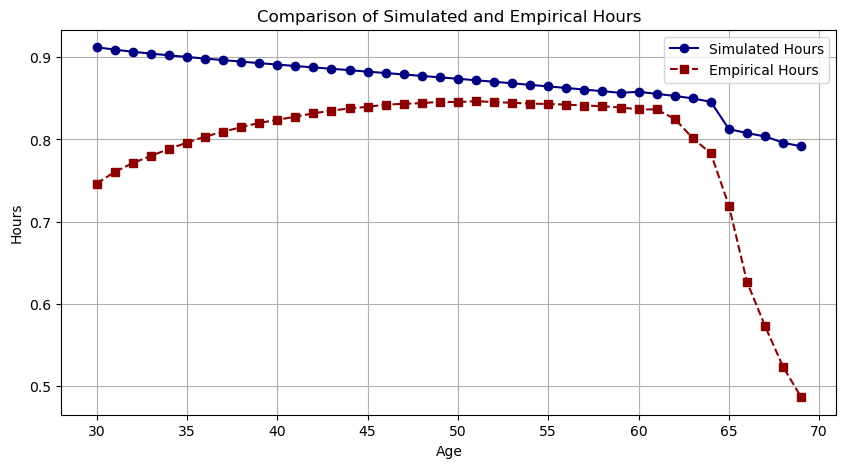

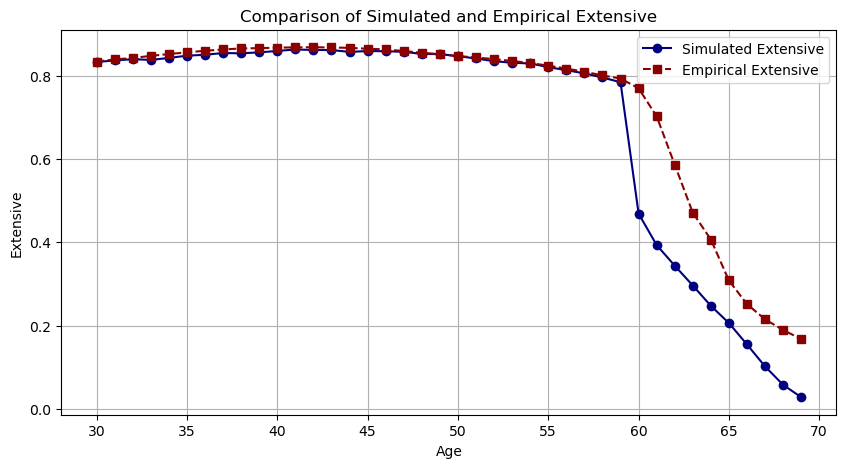

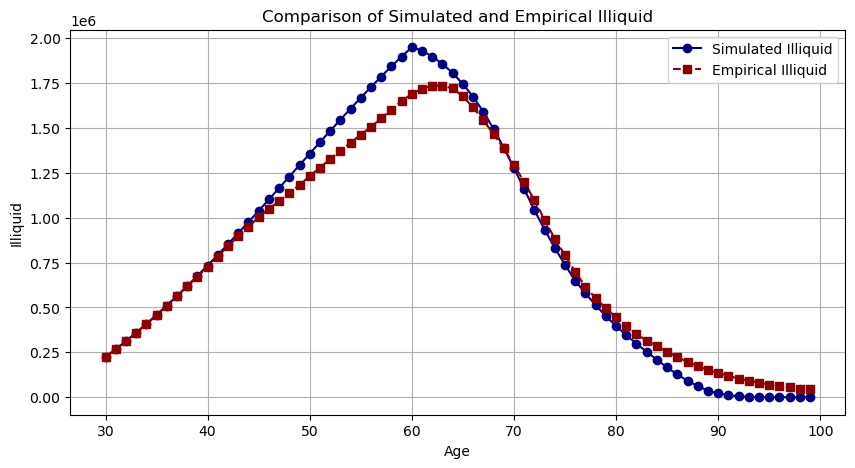

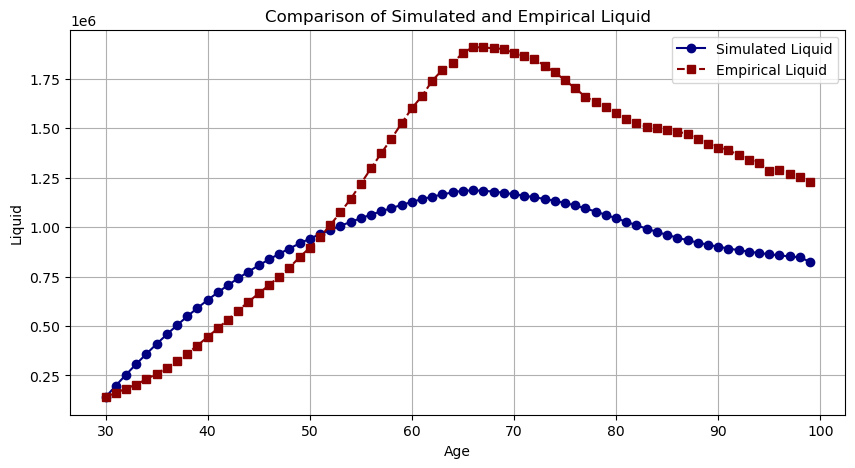

In [8]:
# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
np.minimum(0,1)

np.int64(0)

Old best variables:

In [ ]:
theta_old = ([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])